# ver2
* changing to resnet50

* adding function to plot competition csv

* data augmentation

In [1]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

plt.ion()   # interactive mode

def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

train_df = pd.read_csv('../data/train.csv')

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(os.getcwd(),data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



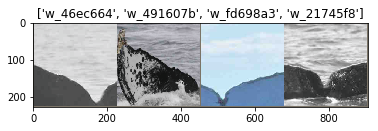

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [23]:

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4251)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
------------------





In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 8.3628 Acc: 0.0844
val Loss: 8.3348 Acc: 0.0412

Epoch 1/19
----------
train Loss: 7.9322 Acc: 0.0850
val Loss: 8.4052 Acc: 0.0412

Epoch 2/19
----------
train Loss: 7.8031 Acc: 0.0850
val Loss: 9.1490 Acc: 0.0412

Epoch 3/19
----------
train Loss: 7.7522 Acc: 0.0850
val Loss: 9.7738 Acc: 0.0412

Epoch 4/19
----------


KeyboardInterrupt: 

# Testing the network on the test set

In [9]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [13]:
batch_size = 512
num_workers = 0

test_set = WhaleDataset(datafolder='../data/test', datatype='test', transform=data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)



In [28]:
y, le = prepare_labels(train_df['Id'])

sub = pd.read_csv('sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)

C:\Users\Carmels\Anaconda3\envs\torchenv\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [25]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4251)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=500)

Epoch 0/499
----------
train Loss: 9.3867 Acc: 0.0209
val Loss: 14.6436 Acc: 0.0416

Epoch 1/499
----------
train Loss: 9.1817 Acc: 0.0283
val Loss: 21.1791 Acc: 0.0485

Epoch 2/499
----------
train Loss: 5.0131 Acc: 0.2226
val Loss: 8.7213 Acc: 0.2923

Epoch 3/499
----------
train Loss: 4.1852 Acc: 0.2570
val Loss: 7.1557 Acc: 0.3026

Epoch 4/499
----------
train Loss: 3.9477 Acc: 0.2776
val Loss: 5.7095 Acc: 0.3763

Epoch 5/499
----------
train Loss: 3.8513 Acc: 0.2855
val Loss: 7.6142 Acc: 0.3688

Epoch 6/499
----------
train Loss: 3.7960 Acc: 0.2904
val Loss: 7.1391 Acc: 0.3578

Epoch 7/499
----------
train Loss: 3.7436 Acc: 0.2939
val Loss: 9.9366 Acc: 0.3481

Epoch 8/499
----------
train Loss: 3.6601 Acc: 0.3058
val Loss: 7.1659 Acc: 0.3698

Epoch 9/499
----------
train Loss: 3.2670 Acc: 0.3723
val Loss: 6.0782 Acc: 0.3998

Epoch 10/499
----------
train Loss: 3.2036 Acc: 0.3861
val Loss: 6.6140 Acc: 0.3885

Epoch 11/499
----------
train Loss: 3.1326 Acc: 0.3972
val Loss: 7.3171 A

KeyboardInterrupt: 